In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

In [2]:
sns.set()

# Exercise session 3: Sampling with Metropolis and MCMC

We stick with the Beta-binomial problem:

Let us consider a coin that falls heads with probability $\theta=0.25$ (assumed unknown). 

Our prior knowledge of $\theta$ is encoded in a Beta distributions with parameters $a=20$ and $b=10$:

$$ p_{\rm prior}(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1-\theta)^{b-1}, \qquad \theta \in [0, 1],$$

where $B(a,b)$ is a proper normalization constant such that $\int_{0}^1 p_{\rm prior}(\theta) \; d \theta = 1.$ 

We toss the coin $n$ times and measure a number $y$ of heads. How does our belief of $\theta$ change with the measurement?

In [3]:
a = 20 # prior: parameter a
b = 10 # prior: parameter b
n = 50 # likelihood: number of tosses
y = 15 # likelihood: number of HEADs observed. (Fixed in this example. It could be sampled form a binomial instead)

## Approach 1: Exact derivation

* Obtain the prior and posterior distributions in closed-form

In [4]:
a_post = a + y
b_post = b + n - y
prior_dist = stats.beta(a=a, b=b)
post_dist = stats.beta(a=a_post, b=b_post) # closed-form expression...

* Plot the prior and posterior distributions, together with their 95% HDI

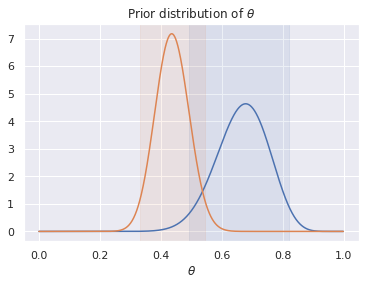

In [5]:
dtheta = 1e-3 # discretization step for theta
theta_vec = np.arange(0, 1, dtheta) # discretized theta range
alpha = 0.05
plt.plot(theta_vec, prior_dist.pdf(theta_vec), label="prior", color="C0")
prior_L, prior_H = prior_dist.interval(1-alpha)
plt.axvspan(xmin=prior_L, xmax=prior_H, alpha=0.1, color="C0", label=r"HDI 95%")
plt.plot(theta_vec, post_dist.pdf(theta_vec), label="posterior", color="C1")
post_L, post_H = post_dist.interval(1-alpha)
plt.axvspan(xmin=post_L, xmax=post_H, alpha=0.1, color="C1", label=r"HDI 95%")
#plt.axvline(theta_0, color="black", label=r"true $\theta$")
plt.xlabel(r"$\theta$")
plt.title(r"Prior distribution of $\theta$");

* What are the limitations of the exact derivation approach?

It is only applicable to special cases (conjugacy)

## Approach 2: Gridding

* Obtain functional form of the prior, the likelihood, and of the unnormalized posterior

In [6]:
prior_fun = lambda theta: stats.beta.pdf(theta, a, b)
lik_fun = lambda theta: (theta ** y) * (1 - theta)**(n-y)

def unnorm_prior_fun(theta):
    p_theta = theta**(a-1)*(1-theta)**(b-1) # since we look for an unnormalized posterior, this is also good enough
    p_theta = p_theta * ((theta <= 1.0) & (theta >= 0.0))
    return p_theta
    
unnorm_post_fun = lambda theta: unnorm_prior_fun(theta)*lik_fun(theta)

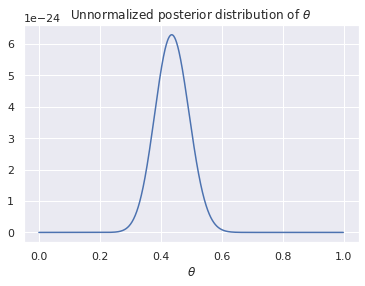

In [7]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, unnorm_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Unnormalized posterior distribution of $\theta$");

* Obtain the normalized posterior by normalizing the unnormalized posterior

In [8]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
Z = np.sum(unnorm_post_fun(theta_vec)) * dtheta
normalized_post_fun = lambda theta: unnorm_post_fun(theta)/Z

* Verify that the gridding approximation of the posterior is close to the exact solution

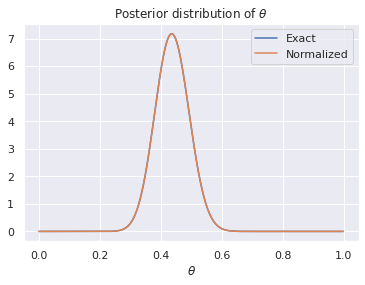

In [9]:
plt.plot(theta_vec, post_dist.pdf(theta_vec), label="Exact")
plt.plot(theta_vec, normalized_post_fun(theta_vec), label="Normalized")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title(r"Posterior distribution of $\theta$");

* What are the limitations of the gridding approach?

It is only applicable in 1/2 dimensions as it suffers the curse of dimensionality.

## Approach 3: Metropolis

* Implement a Metropolis algorithm to obtain a sample-based approximation of the posterior. 
    * Use as target distribution the unnormalized posterior unnorm_post_fun
    * Use the following proposal:
    $$\theta_{\rm proposal} = \theta_{\rm current} + \Delta \theta, \qquad \Delta \theta \sim \mathcal{N}(0, \sigma^2).$$
    * Set $\sigma = 0.1$ and initialize $\theta_{\rm current} = 0.5$
    * Run a single chain of length 50000.

In [10]:
sigma = 0.1 # proposal standard deviation
theta_0 = 0.5 # a lucky guess...
N = 50_000 # chain length

In [11]:
theta_step = theta_0
p_step = unnorm_post_fun(theta_step)
thetas = [] # here we collect the theta values from the chain

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    p_prop = unnorm_post_fun(theta_prop) # evaluate unscaled distribution
  
    p_ratio = p_prop/p_step
    if p_ratio > 1:
        accept = True
    else:
        accept =  np.random.binomial(1, p_ratio) # othewise, accept w.p. p_ratio
        #accept = scipy.stats.bernoulli(p_ratio).rvs() # way slower
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

* Compare the Metropolis samples with the theoretical distribution. What do you observe?

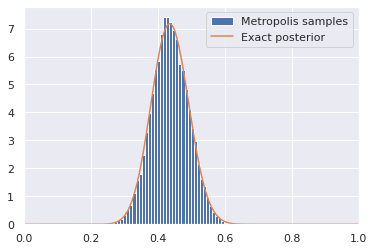

In [12]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, post_dist.pdf(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);

The samples seem to approximate the posterior very well

## Logarithm implementation 
The unnormalized posterior distribution has a bad numerical scaling (in this case, and in general!). In some cases, this can become an issue.
The standard approach is to work out all operations in log-domain:

\begin{align*}
\ell(\theta) &= \log \mathcal{L}(\theta) = {n \choose y} + y \log (\theta) + (n-y) \log (1-\theta) \\
 \log p_{\rm prior}(\theta) &= -\log({B(a,b)}) + (a-1) \log (\theta) + (b-1)\log(1-\theta) \\
 \log p_{\rm post}(\theta) &= \ell(\theta) + \log p_{\rm prior}(\theta) + \log p(y).
\end{align*}


In [13]:
def log_lik_fun(theta):

    eps = 1e-12
    theta = np.minimum(theta, 1 - eps)
    theta = np.maximum(theta, eps)
    
    log_lik =  y * np.log(theta) + (n-y)*np.log(1 - theta)
    return log_lik

def unnorm_log_prior_fun(theta):
    
    eps = 1e-12
    theta = np.minimum(theta, 1 - eps)
    theta = np.maximum(theta, eps)

    log_p_theta = (a-1)*np.log(theta) + (b-1)*np.log(1-theta) 
    log_p_theta = log_p_theta * ((theta <= 1.0) & (theta >= 0.0))
    return log_p_theta

unnorm_log_post_fun = lambda theta: log_lik_fun(theta) + unnorm_log_prior_fun(theta)

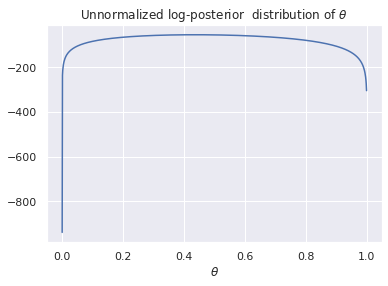

In [14]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, unnorm_log_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Unnormalized log-posterior  distribution of $\theta$");

The log-posterior has a much better scaling!

Actually, all we need to implement Metropolis is the ratio:
$$p_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current}) = \frac{p_{\rm post}(\theta_{\rm proposal})}{p_{\rm post}(\theta_{\rm current})}$$
Then, $p_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current})$  may be computed in a numerically stable way by exponentiating the difference between the log-posteriors at $\theta_{\rm proposal}$ and $\theta_{\rm current}$,  exploiting the identity:


$$p_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current}) = e^{(\log p_{\rm post}(\theta_{\rm proposal})- \log p_{\rm post}(\theta_{\rm current}))}.$$

The additive constant disappears from the difference between the log-likelihood in 2 points, and the quantity to be exponentiated is not too large!

In general, the *golden rule* is to perform as many operations as possible in the log domain and go back only when it is strictly necessary.

* Implement a python function p_ratio_fun to compute $p_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm current})$, exploiting the above trick

In [15]:
def p_ratio_fun(theta_propose, theta_current):
       
    log_p_propose = unnorm_log_post_fun(theta_propose)
    log_p_current = unnorm_log_post_fun(theta_current)
    log_p_ratio = log_p_propose - log_p_current # log(p_prop/p_prev) = log(p_prop) - log(p_prev)
    p_ratio = np.exp(log_p_ratio)
    #p_ratio = np.nan_to_num(p_ratio, nan=0.0)
    return p_ratio

* Implement a Metropolis algorithm using the newly defined p_ratio_fun

In [16]:
theta_step = theta_0
thetas = [] # here we collect the theta values from the chain

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    theta_prop = np.clip(theta_prop, 0, 1)
    
    p_ratio = p_ratio_fun(theta_prop, theta_step)
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

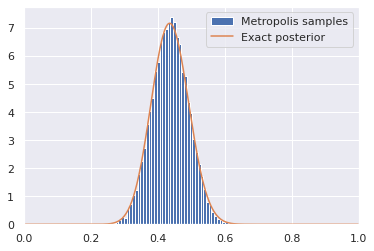

In [17]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, post_dist.pdf(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);

We obtain the same result as before.

* Try our different values of sigma and comment the results

In [18]:
sigma = 0.1 # proposal standard deviation
theta_0 = 0.5 # a lucky guess...
N = 50_000 # chain length

theta_step = theta_0
thetas_test = [] # here we collect the theta values from the chain

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    theta_prop = np.clip(theta_prop, 0, 1)
    
    p_ratio = p_ratio_fun(theta_prop, theta_step)
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

## Approach 4: Probabilistic Programming

The Beta-Binomial is the Hello World of probabilistic programming! No need to worry about implementation subtleties of sampling, pymc3 takes care of it!

In [19]:
# Approach 2: use pymc(3)

with pm.Model() as beta_binomial:
    theta = pm.Beta("theta", alpha=a, beta=b)
    y_obs = pm.Binomial("y_obs", n=n, p=theta, observed=y)
    trace_bb = pm.sample(10_000, random_seed=123, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 6 seconds.


In [20]:
with beta_binomial:
    display(az.summary(trace_bb))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.438,0.055,0.337,0.542,0.0,0.0,17310.0,27715.0,1.0


In [21]:
np.mean(thetas), np.std(thetas) # comparison with hand-made metropolis

(0.4376651215014064, 0.05437089550055235)

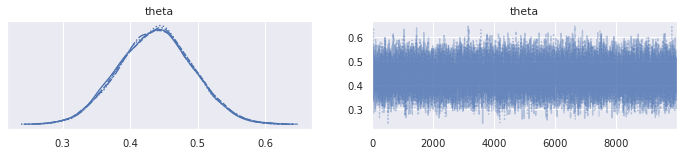

In [22]:
az.plot_trace(trace_bb);

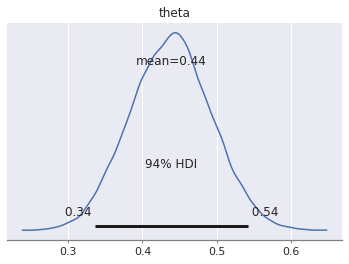

In [23]:
az.plot_posterior(trace_bb, color="b");

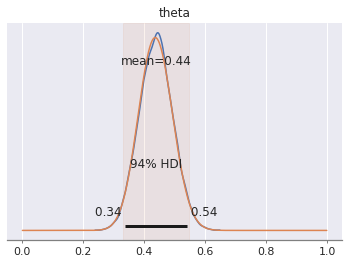

In [24]:
az.plot_posterior(trace_bb, color="C0")
plt.plot(theta_vec, post_dist.pdf(theta_vec), color="C1")
post_L, post_H = post_dist.interval(1-alpha)
plt.axvspan(xmin=post_L, xmax=post_H, alpha=0.1, color="C1", label=r"HDI 95%");